In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

# get data

In [3]:
ddir = '../data/cheng21_cell_scrna/organized/'
files = [
    'P28NR.h5ad',
    'P28DR.h5ad',
] 

In [4]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = 2,4,20,-1

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    mat = adata.X
    types = adata.obs['Subclass'].astype(str).values 
    # 1 or 2
    # sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P28NR.h5ad
['1a_Astro' '1a_Endo' '1a_Frem1' '1a_L2/3' '1a_L4' '1a_L5IT' '1a_L5NP'
 '1a_L5PT' '1a_L6CT' '1a_L6IT' '1a_L6b' '1a_Lamp5' '1a_Micro' '1a_OD'
 '1a_OPC' '1a_Pvalb' '1a_Sst' '1a_Stac' '1a_VLMC' '1a_Vip' '1b_Astro'
 '1b_Endo' '1b_Frem1' '1b_L2/3' '1b_L4' '1b_L5IT' '1b_L5NP' '1b_L5PT'
 '1b_L6CT' '1b_L6IT' '1b_L6b' '1b_Lamp5' '1b_Micro' '1b_OD' '1b_OPC'
 '1b_Pvalb' '1b_Sst' '1b_Stac' '1b_VLMC' '1b_Vip' '2a_Astro' '2a_Endo'
 '2a_Frem1' '2a_L2/3' '2a_L4' '2a_L5IT' '2a_L5NP' '2a_L5PT' '2a_L6CT'
 '2a_L6IT' '2a_L6b' '2a_Lamp5' '2a_Micro' '2a_OD' '2a_OPC' '2a_Pvalb'
 '2a_Sst' '2a_Stac' '2a_VLMC' '2a_Vip' '2b_Astro' '2b_Endo' '2b_Frem1'
 '2b_L2/3' '2b_L4' '2b_L5IT' '2b_L5NP' '2b_L5PT' '2b_L6CT' '2b_L6IT'
 '2b_L6b' '2b_Lamp5' '2b_Micro' '2b_OD' '2b_OPC' '2b_Pvalb' '2b_Sst'
 '2b_Stac' '2b_VLMC' '2b_Vip']
(80, 53801)
P28DR.h5ad
(80, 53801)
(2, 80, 53801)
(2, 4, 20, 53801)


In [5]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((2, 4, 20), True)

In [6]:
xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short

array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
       'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
       'Sst', 'Stac', 'VLMC', 'Vip'], dtype='<U5')

# filter out small bulk profiles

In [7]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

,0,1,2,3,4,5,6,7
Astro,463,305,458,350,610,635,637,670
Endo,83,241,55,231,142,163,145,179
Frem1,20,15,19,14,29,21,31,20
L2/3,1050,951,1021,1060,943,1354,1030,1339
L4,1193,881,1236,954,1097,1398,1206,1378
L5IT,221,184,165,186,237,275,226,292
L5NP,80,60,73,71,124,110,118,105
L5PT,163,202,182,218,160,241,203,240
L6CT,717,588,652,550,744,938,802,932
L6IT,336,320,335,342,372,508,393,514


In [8]:
numcells.min(axis=1).sort_values()

Stac       4
Frem1     14
VLMC      32
L6b       44
Lamp5     45
Vip       53
Endo      55
L5NP      60
Pvalb     86
OPC      109
Sst      111
L5PT     160
L5IT     165
Micro    203
OD       249
Astro    305
L6IT     320
L6CT     550
L4       881
L2/3     943
dtype: int64

In [9]:
xclsts_sel = xclsts_short[numcells.min(axis=1)>50]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx

(array(['Astro', 'Endo', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT',
        'L6IT', 'Micro', 'OD', 'OPC', 'Pvalb', 'Sst', 'Vip'], dtype='<U5'),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19]))

# filter out unexpressed genes

In [10]:
tensor_nr = pbulks[0].T
tensor_dr = pbulks[1].T
tensor_nr.shape, tensor_dr.shape

((53801, 15, 4), (53801, 15, 4))

In [11]:
expressed_nr  = np.any(np.mean(tensor_nr, axis=2) > np.log10(1+1), axis=1) # mean exp of CPM=1 in any subclass
expressed_dr  = np.any(np.mean(tensor_dr, axis=2) > np.log10(1+1), axis=1) 
expressed_any = np.logical_or(expressed_nr, expressed_dr)
expressed_nr.sum(), expressed_dr.sum(), expressed_any.sum()

(19541, 19144, 20062)

In [12]:
genes_comm = genes[expressed_any]
genes_cidx = basicu.get_index_from_array(genes, genes_comm)
assert np.any(genes_cidx!=-1)

tensor_nr = pbulks[0].T[genes_cidx]
tensor_dr = pbulks[1].T[genes_cidx]

genes_comm, tensor_nr.shape

(array(['Xkr4', 'Gm1992', 'Rp1', ..., 'AC125149.3', 'AC149090.1',
        'CAAA01118383.1'], dtype=object),
 (20062, 15, 4))

In [13]:
idx = np.arange(len(genes))[~expressed_any]
tensor_nr_ctrl = pbulks[0].T[idx]
tensor_dr_ctrl = pbulks[1].T[idx]

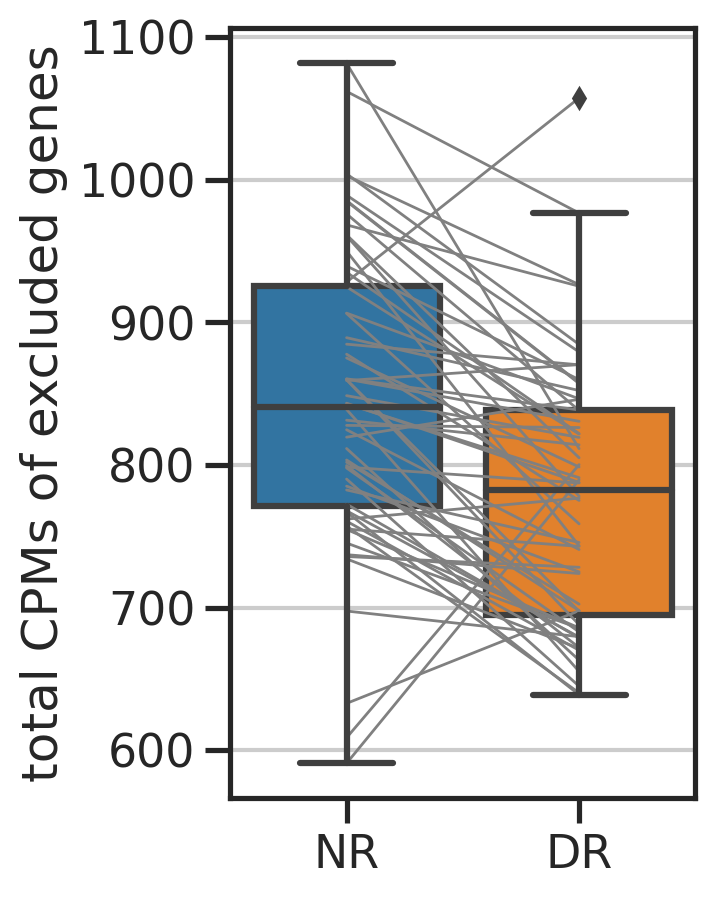

In [14]:
a = np.sum(np.power(10, tensor_nr_ctrl)-1, axis=0).ravel()
b = np.sum(np.power(10, tensor_dr_ctrl)-1, axis=0).ravel()

fig, ax = plt.subplots(figsize=(3,5))
for ai, bi in zip(a,b):
    ax.plot([0,1], [ai,bi], '-', color='gray', linewidth=1, markersize=1)
sns.boxplot([a,b], ax=ax)
ax.set_ylabel('total CPMs of excluded genes')
ax.set_xticklabels(['NR', 'DR'])
plt.show()

# Do the tests

In [15]:
# for each gene and cell type; 4 rep vs 4 rep - t-test and p-val correction 
lfc = np.mean(tensor_dr, axis=2) - np.mean(tensor_nr, axis=2) # log10FC (log10CPM as raw counts)
higherexp = np.maximum(np.mean(tensor_dr, axis=2), np.mean(tensor_nr, axis=2)) # mean exp for every gene type pair in the higher expressed condition
ts, ps = ttest_ind(tensor_nr, tensor_dr, axis=2)
rejs, qs, _, _ = multipletests(np.nan_to_num(ps, nan=1).reshape(-1,), method='fdr_bh')
rejs = rejs.reshape(ps.shape)
qs = qs.reshape(ps.shape)

In [16]:
# ps_nonnan = ps.reshape(-1,)
# print(ps_nonnan.shape)
# ps_nonnan = ps_nonnan[~np.isnan(ps_nonnan)]
# ps_nonnan.shape
np.isnan(ps).sum()

13159

In [17]:
lfc.shape, rejs.shape, qs.shape, np.sum(np.sum(rejs, axis=1) > 0), np.sum(rejs, axis=0) 

((20062, 15),
 (20062, 15),
 (20062, 15),
 2802,
 array([ 435,   84, 1194,  671,  293,   49,  254,  552,  435,   44,   76,
          44,   64,  114,   87]))

In [18]:
fc = 2
cond1 = rejs # FDR< 0.05
cond2 = np.abs(lfc) > np.log10(fc) 
cond2up = lfc >  np.log10(fc) 
cond2dn = lfc < -np.log10(fc) 
cond3 = higherexp > np.log10(100+1) # 

sigsigs = np.all([cond1, cond2, cond3], axis=0)
sigsigs.shape, np.sum(np.sum(sigsigs, axis=1) > 0), np.sum(sigsigs, axis=0)

((20062, 15),
 174,
 array([52, 17, 69, 13, 20,  1,  9, 31, 42,  3,  4,  1,  0,  5,  9]))

In [19]:
sigsigs_up = np.all([cond1, cond2up, cond3], axis=0)
sigsigs_up.shape, np.sum(np.sum(sigsigs_up, axis=1) > 0), np.sum(sigsigs_up, axis=0)

((20062, 15),
 145,
 array([43, 14, 61, 13, 17,  1,  8, 29, 42,  3,  0,  1,  0,  5,  9]))

In [20]:
sigsigs_dn = np.all([cond1, cond2dn, cond3], axis=0)
sigsigs_dn.shape, np.sum(np.sum(sigsigs_dn, axis=1) > 0), np.sum(sigsigs_dn, axis=0)

((20062, 15), 29, array([9, 3, 8, 0, 3, 0, 1, 2, 0, 0, 4, 0, 0, 0, 0]))

In [21]:
sigsum = pd.DataFrame(index=unq_types)
# sigsum['all']   = np.sum(sigsigs, axis=0)
sigsum['DR_up'] = np.sum(sigsigs_up, axis=0)
sigsum['DR_dn'] = np.sum(sigsigs_dn, axis=0)
sigsum

,DR_up,DR_dn
Astro,43,9
Endo,14,3
L2/3,61,8
L4,13,0
L5IT,17,3
L5NP,1,0
L5PT,8,1
L6CT,29,2
L6IT,42,0
Micro,3,0


# show results

In [22]:
def extract_res_onetype(idx):
    return genes_comm[sigsigs_up[:,idx]], genes_comm[sigsigs_dn[:,idx]]

In [23]:
def show_onetype(idx):
    """idx - cell type idx
    """
    gidx_up = sigsigs_up[:,idx]
    gidx_dn = sigsigs_dn[:,idx]
    gidx_bth = np.logical_or(gidx_up, gidx_dn)
    _genes = genes_comm[gidx_bth]

    p_nr = tensor_nr[gidx_bth,idx,:]
    p_dr = tensor_dr[gidx_bth,idx,:]
    
    this_mlfc = np.mean(p_nr, axis=1) - np.mean(p_dr, axis=1)
    this_ordr = np.argsort(this_mlfc)
    
    ab = np.hstack([p_nr, p_dr])
    ab = (ab - np.mean(ab, axis=1).reshape(-1,1)) #/np.std(ab, axis=1).reshape(-1,1)
    ab = pd.DataFrame(ab[this_ordr], 
                      index=_genes[this_ordr], 
                      columns=["NR_1a", "NR_1b", "NR_2a", "NR_2b", 
                               "DR_1a", "DR_1b", "DR_2a", "DR_2b",
                              ],
                     )
    
    fig, ax = plt.subplots(figsize=(4, min(10, 0.3*len(ab))))
    sns.heatmap(ab, center=0, cmap='coolwarm', yticklabels=True, cbar_kws=dict(shrink=0.5, label='log10 FC'))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(unq_types[idx])
    plt.show()

In [24]:
def show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2, cond3, ax=None, bbox_to_anchor=(1,1), loc=None):
    """
    """
    eff = lfc[:,thetypeidx]
    pvl =  qs[:,thetypeidx]

    cnd_s1 = np.all([cond1[:,thetypeidx], 
                     cond2[:,thetypeidx]], axis=0) 
    cnd_s2 = np.all([cond1[:,thetypeidx], 
                     cond2[:,thetypeidx], 
                     cond3[:,thetypeidx]], axis=0) 

    if ax is None:
        fig, ax = plt.subplots()
    else:
        pass
    ax.scatter(eff, -np.log10(pvl), s=1, color='gray')

    ax.scatter(eff[cnd_s1], -np.log10(pvl)[cnd_s1], s=2, 
               label=f'sig effect (n={cnd_s1.sum():,})')
    ax.scatter(eff[cnd_s2], -np.log10(pvl)[cnd_s2], s=10, facecolors='none', edgecolors='C1', 
               label=f'picked (n={cnd_s2.sum():,})', 
              )

    ax.set_xlabel('log10(FC) (DR/NR in CPM)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'{thetype}')
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    return ax

In [25]:
qs.shape, lfc.shape, cond1.shape, genes_comm.shape

((20062, 15), (20062, 15), (20062, 15), (20062,))

L2/3 2


<Axes: title={'center': 'L2/3'}, xlabel='log10(FC) (DR/NR in CPM)', ylabel='-log10(FDR)'>

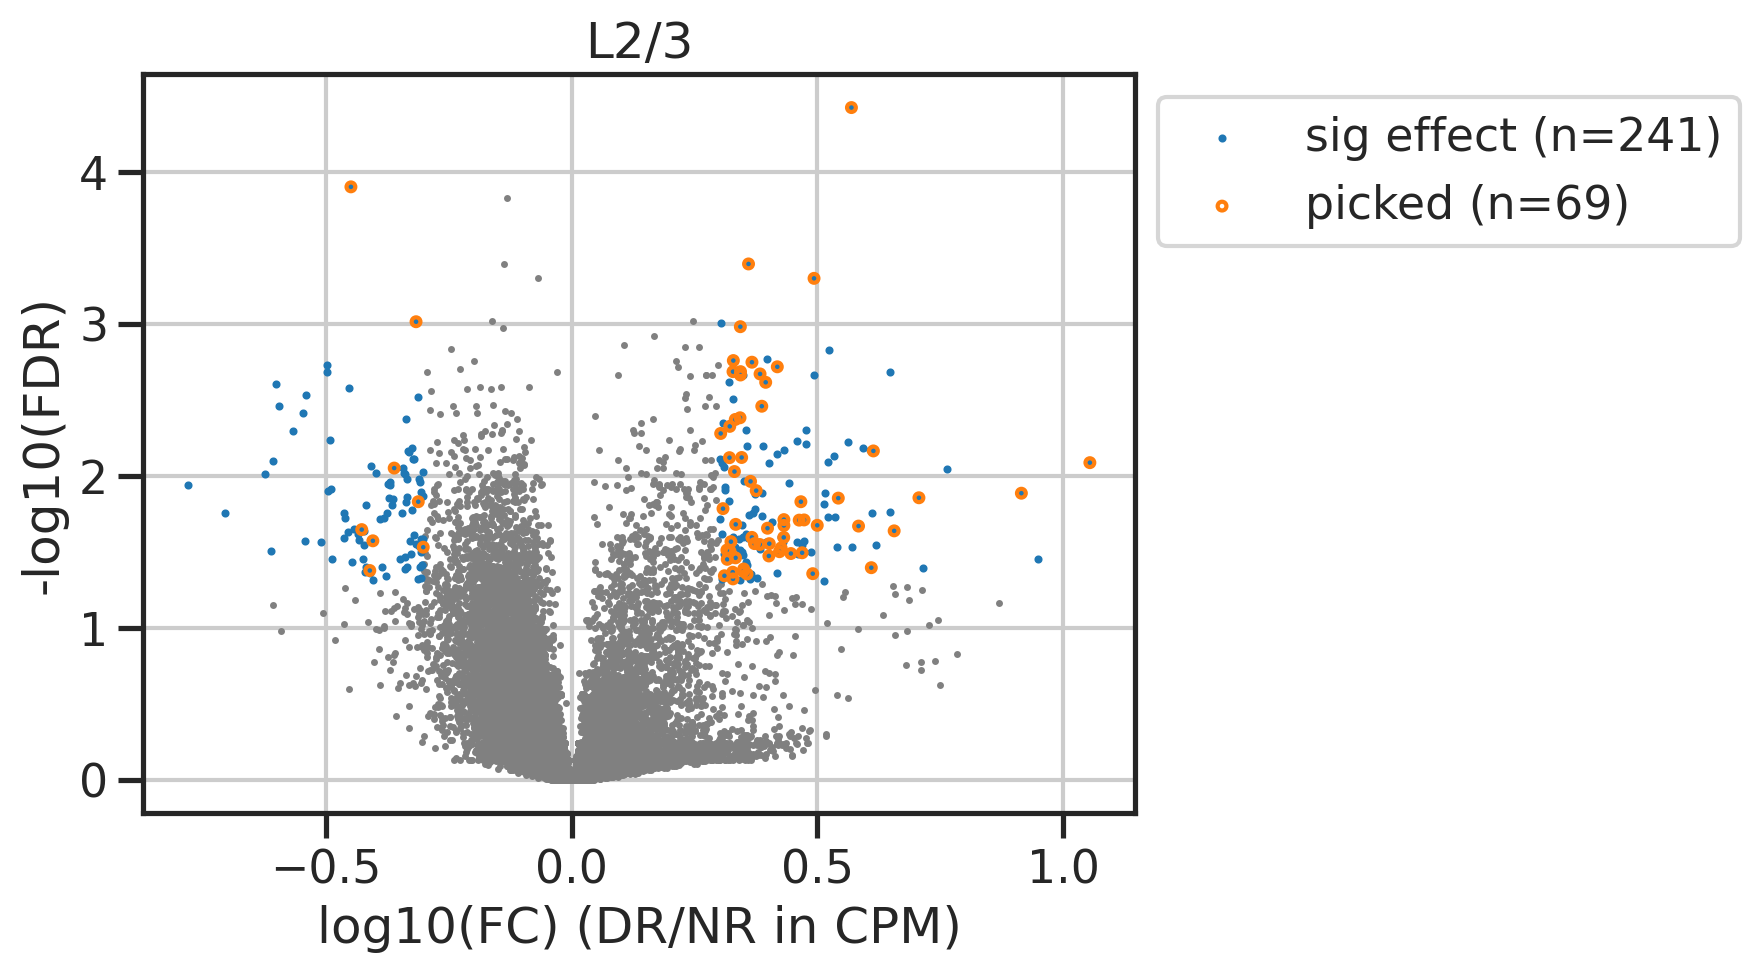

In [26]:
thetype = 'L2/3'
thetypeidx = basicu.get_index_from_array(unq_types, ["L2/3"])[0]
print(thetype, thetypeidx)
show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2, cond3) 

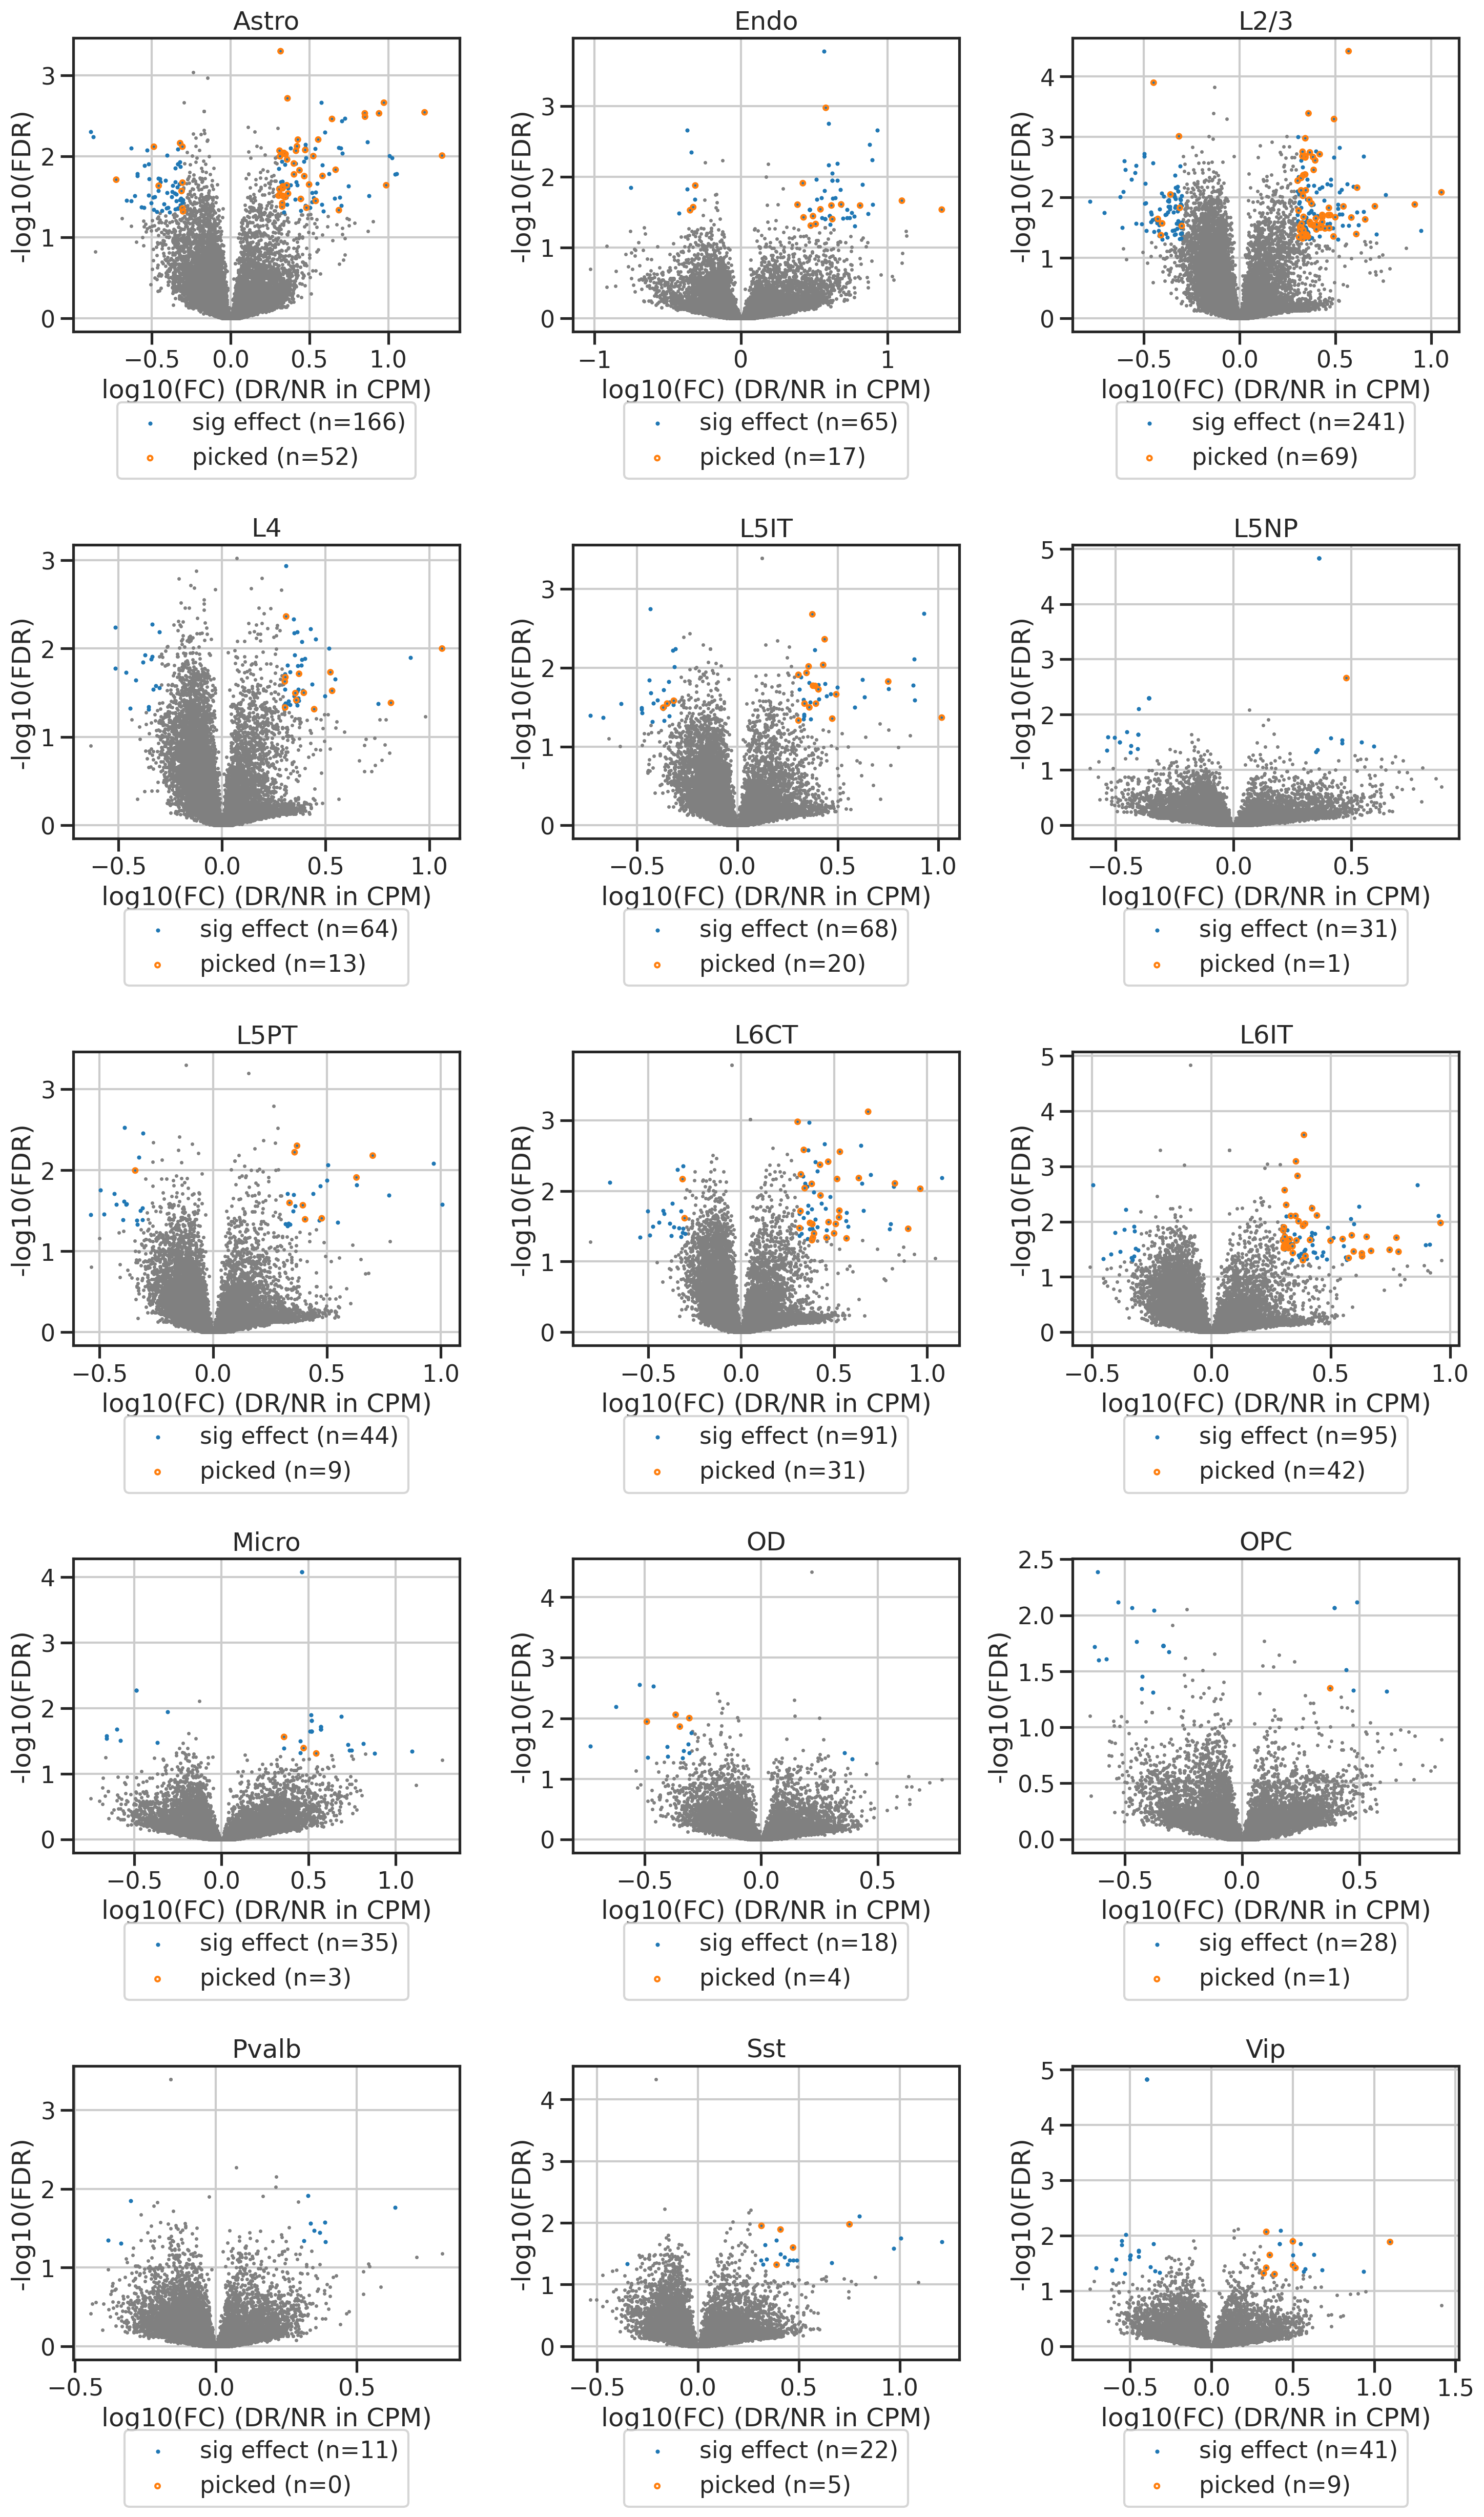

In [27]:
fig, axs = plt.subplots(5,3, figsize=(3*5,5*5))
for thetypeidx, thetype in enumerate(unq_types):
    ax = axs.flat[thetypeidx]
    show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2, cond3, ax=ax, bbox_to_anchor=(0.5, -0.2), loc='upper center') 
fig.tight_layout()
plt.show()

In [28]:
sigsum_genes = sigsum.copy()
ups = []
dns = []
for i, (_type, row) in enumerate(sigsum.iterrows()):
    _up, _dn = extract_res_onetype(i)
    ups.append(", ".join(_up))
    dns.append(", ".join(_dn))
    
sigsum_genes['genes_up'] = ups 
sigsum_genes['genes_dn'] = dns 
sigsum_genes

,DR_up,DR_dn,genes_up,genes_dn
Astro,43,9,"Coq10b, Map3k19, Nmnat2, Bpnt1, Eprs, Man1b1, ...","Ptprj, Gm3764, Mxd4, Eogt, Hif3a, Galnt18, Pro..."
Endo,14,3,"Cntnap5a, Btg2, Atf3, Celf2, Kcnh7, Akap12, Nr...","4930578C19Rik, Clec2d, Zfp366"
L2/3,61,8,"Coq10b, Zdbf2, Nmnat2, Eprs, Arl5b, Slc25a25, ...","Col19a1, Plxdc2, Etl4, Stard8, Pde4b, Nell1, S..."
L4,13,0,"Zdbf2, Nr4a2, Mir670hg, Bdnf, Nr4a3, Rheb, Tbc...",
L5IT,17,3,"Zdbf2, Mir670hg, Egfem1, Cyr61, Rheb, Tbc1d1, ...","Kcnc2, Inf2, Ptchd4"
L5NP,1,0,1700016P03Rik,
L5PT,8,1,"Eprs, Tiparp, Nr4a3, Sik2, 1700016P03Rik, Plcx...",Dnah9
L6CT,29,2,"Zdbf2, Nmnat2, Eprs, Arl5b, Nr4a2, Mir670hg, C...","Nebl, Fstl4"
L6IT,42,0,"Zdbf2, Btg2, Nmnat2, Arl5b, Nr4a2, Bdnf, Med14...",
Micro,3,0,"Grm3, Cntn5, Kctd16",


In [29]:
types_order = [
    'L2/3', 
    'L4', 
    'L5IT', 
    'L6IT', 
    'L5PT', 
    'L5NP', 
    'L6CT', 
    # 'L6b',
    
    'Pvalb', 
    'Sst', 
    'Vip',
    # 'Lamp5', 
    
    # 'Stac', 
    # 'Frem1', 
    
    'Astro', 
    'OD', 
    'OPC',
    'Micro', 
    'Endo', 
    # 'VLMC', 
]


In [30]:
dfres = sigsum_genes.loc[types_order].copy()
dfres
# dfres.to_csv('../results/P28_NR_DR_DEGs_Oct27.csv', header=True, index=True)

,DR_up,DR_dn,genes_up,genes_dn
L2/3,61,8,"Coq10b, Zdbf2, Nmnat2, Eprs, Arl5b, Slc25a25, ...","Col19a1, Plxdc2, Etl4, Stard8, Pde4b, Nell1, S..."
L4,13,0,"Zdbf2, Nr4a2, Mir670hg, Bdnf, Nr4a3, Rheb, Tbc...",
L5IT,17,3,"Zdbf2, Mir670hg, Egfem1, Cyr61, Rheb, Tbc1d1, ...","Kcnc2, Inf2, Ptchd4"
L6IT,42,0,"Zdbf2, Btg2, Nmnat2, Arl5b, Nr4a2, Bdnf, Med14...",
L5PT,8,1,"Eprs, Tiparp, Nr4a3, Sik2, 1700016P03Rik, Plcx...",Dnah9
L5NP,1,0,1700016P03Rik,
L6CT,29,2,"Zdbf2, Nmnat2, Eprs, Arl5b, Nr4a2, Mir670hg, C...","Nebl, Fstl4"
Pvalb,0,0,,
Sst,5,0,"Pard3b, Gad1, 1700016P03Rik, Pcsk1, Homer1",
Vip,9,0,"Nr4a2, Fosl2, Rab6a, Hs3st2, Per1, Ube2ql1, Ho...",


In [31]:
dfplot = sigsum_genes.loc[types_order].iloc[:,:2].copy()

Text(0, 0.5, 'Number of DE genes \n (FDR<0.05, FC>2, max CPM>100)')

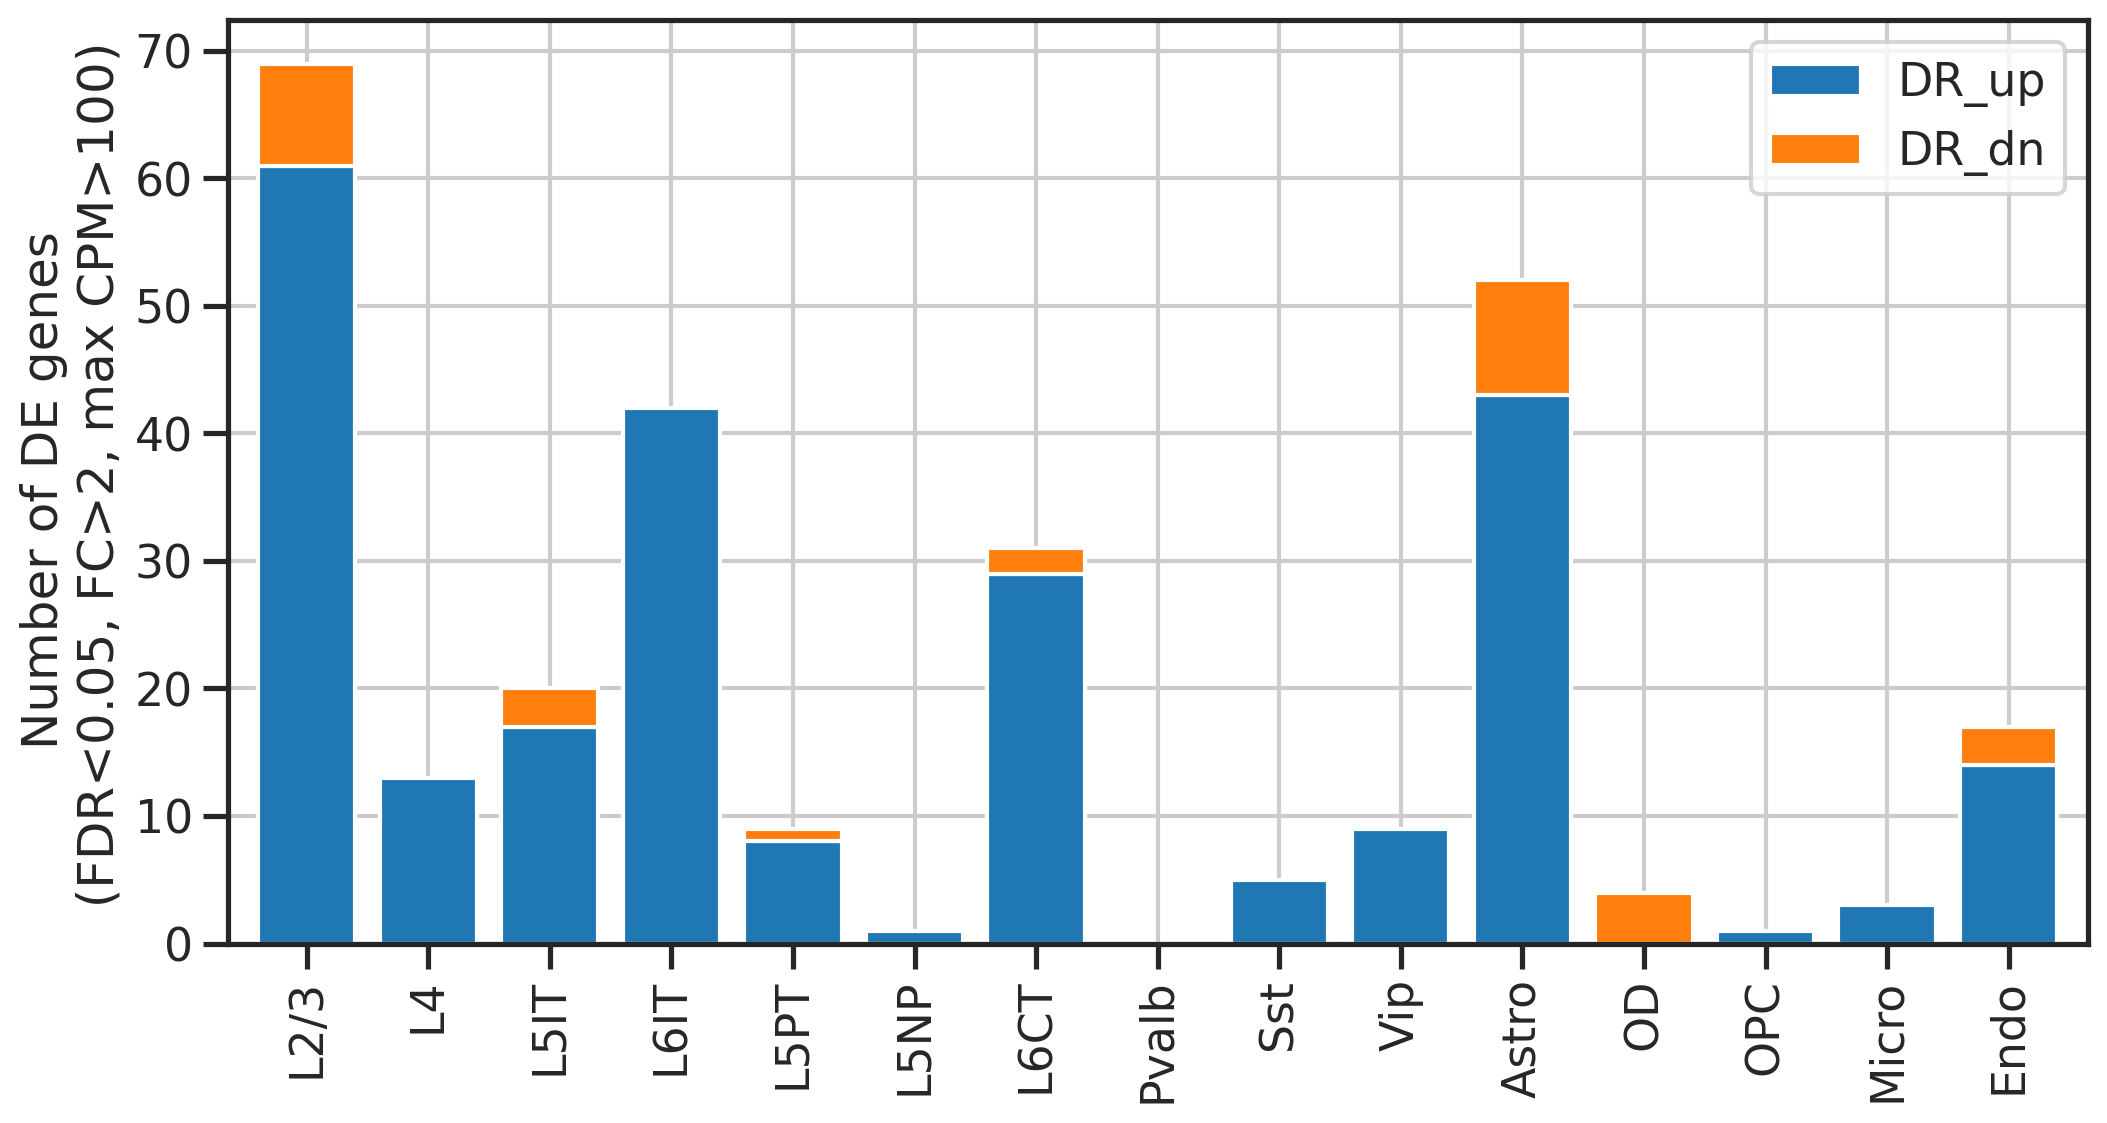

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
dfplot.plot.bar(stacked=True, width=0.8, ax=ax)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC>2, max CPM>100)')

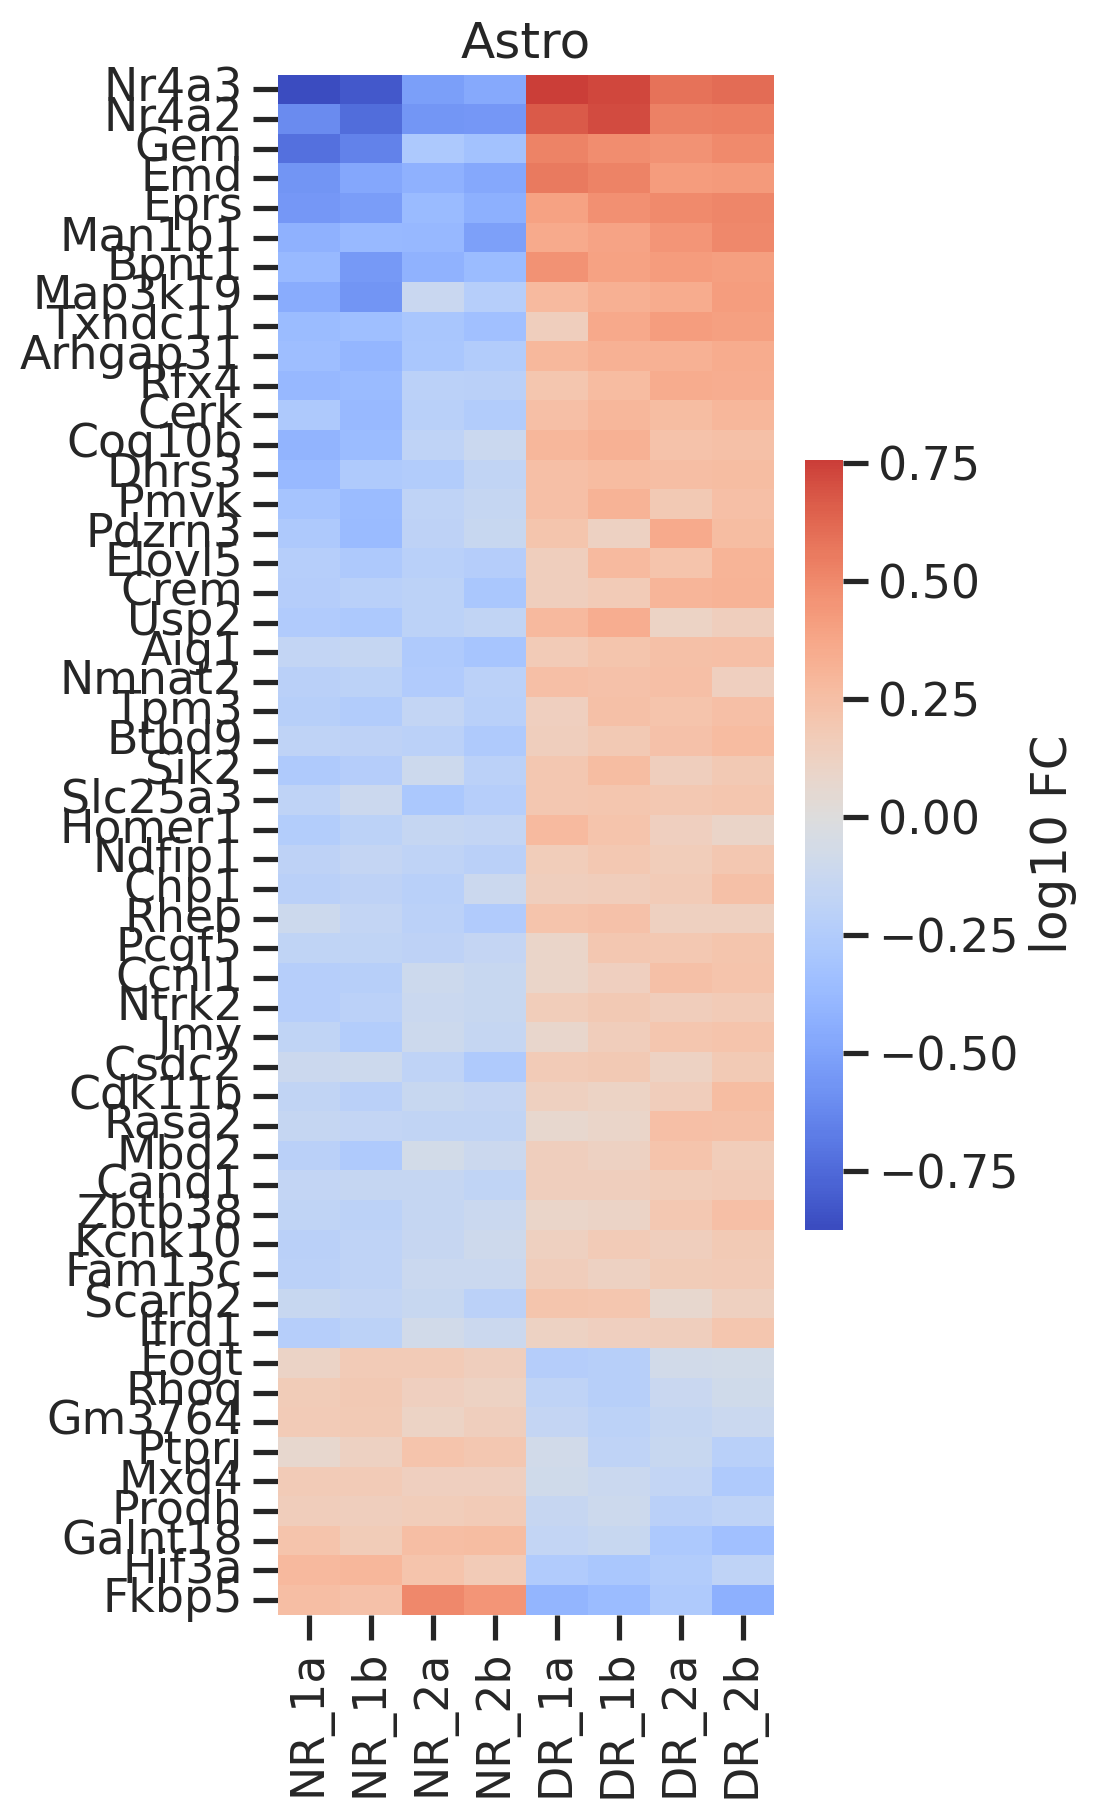

In [33]:
show_onetype(0)

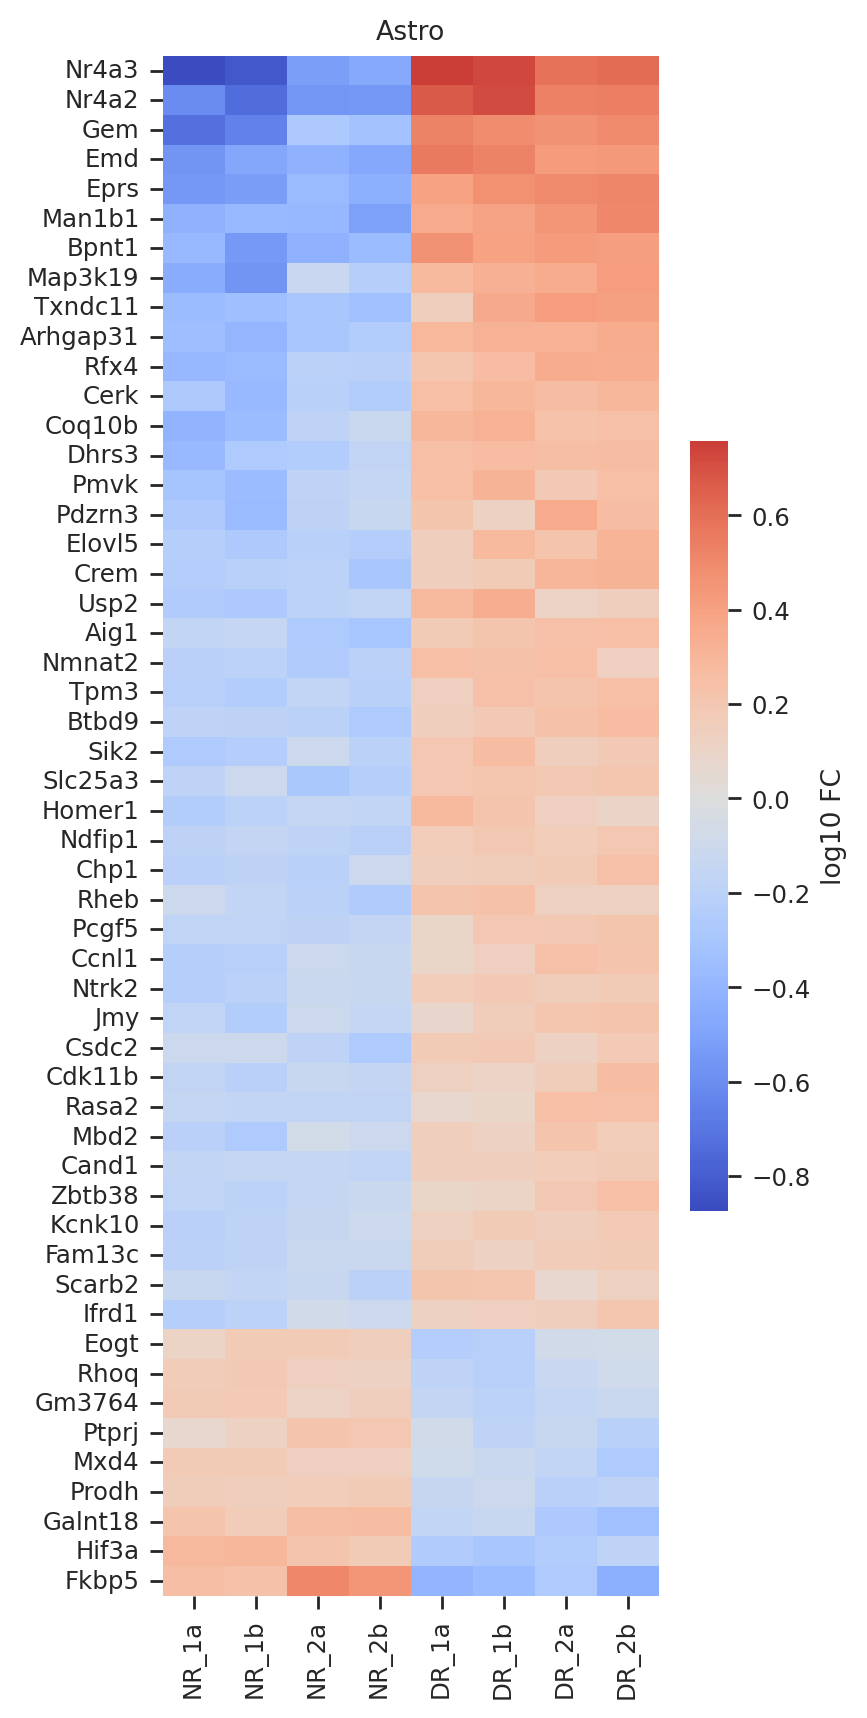

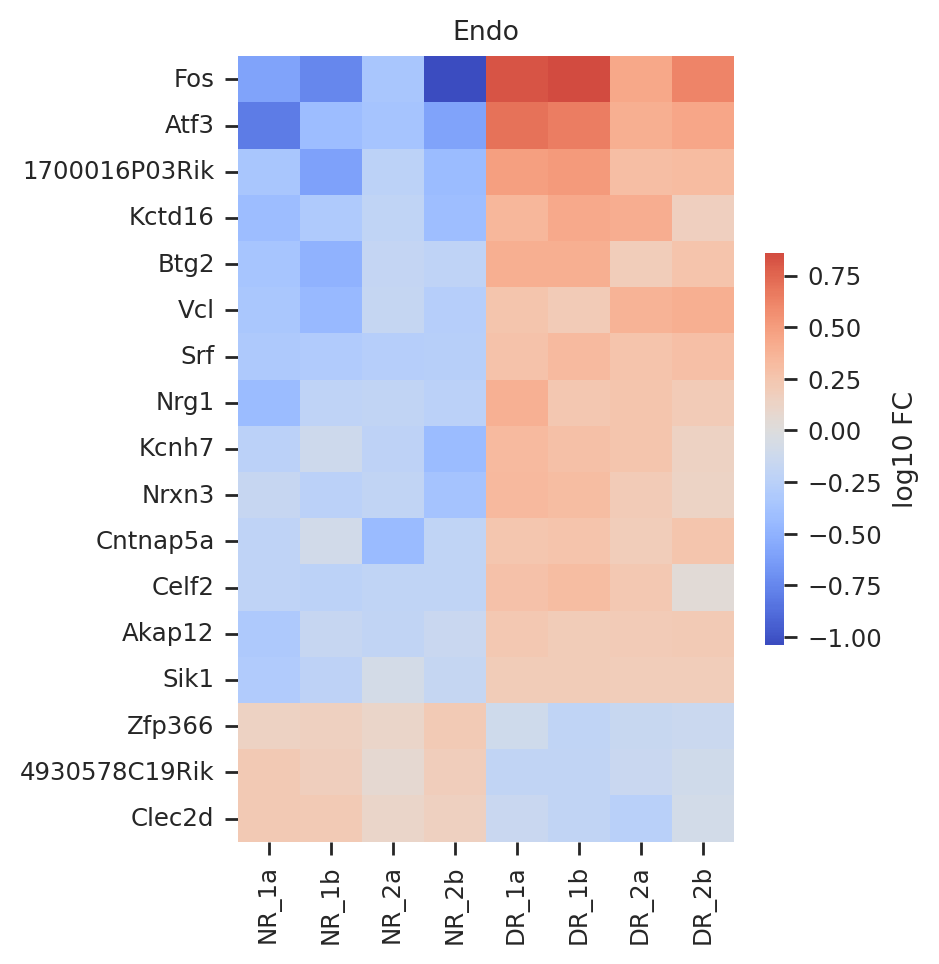

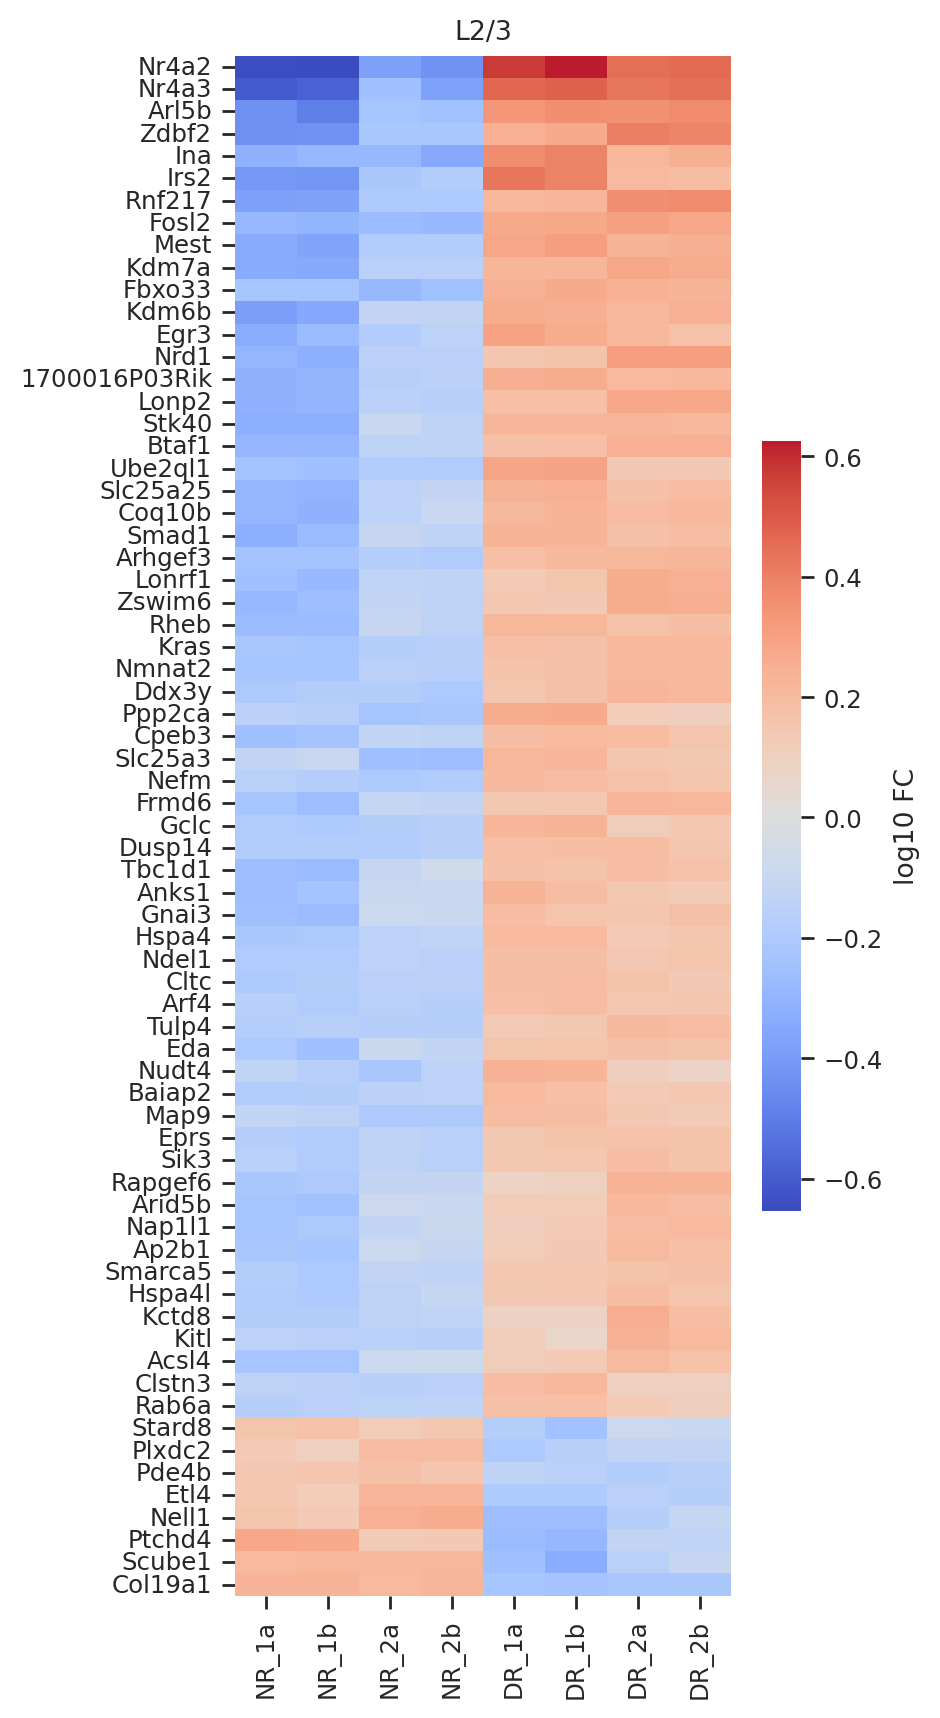

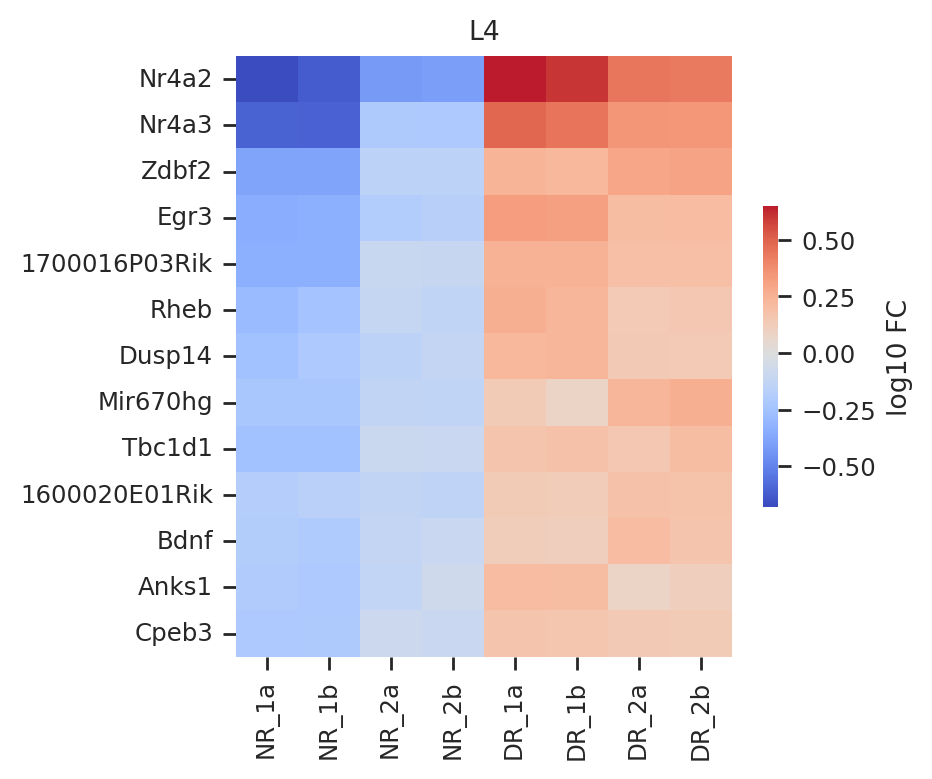

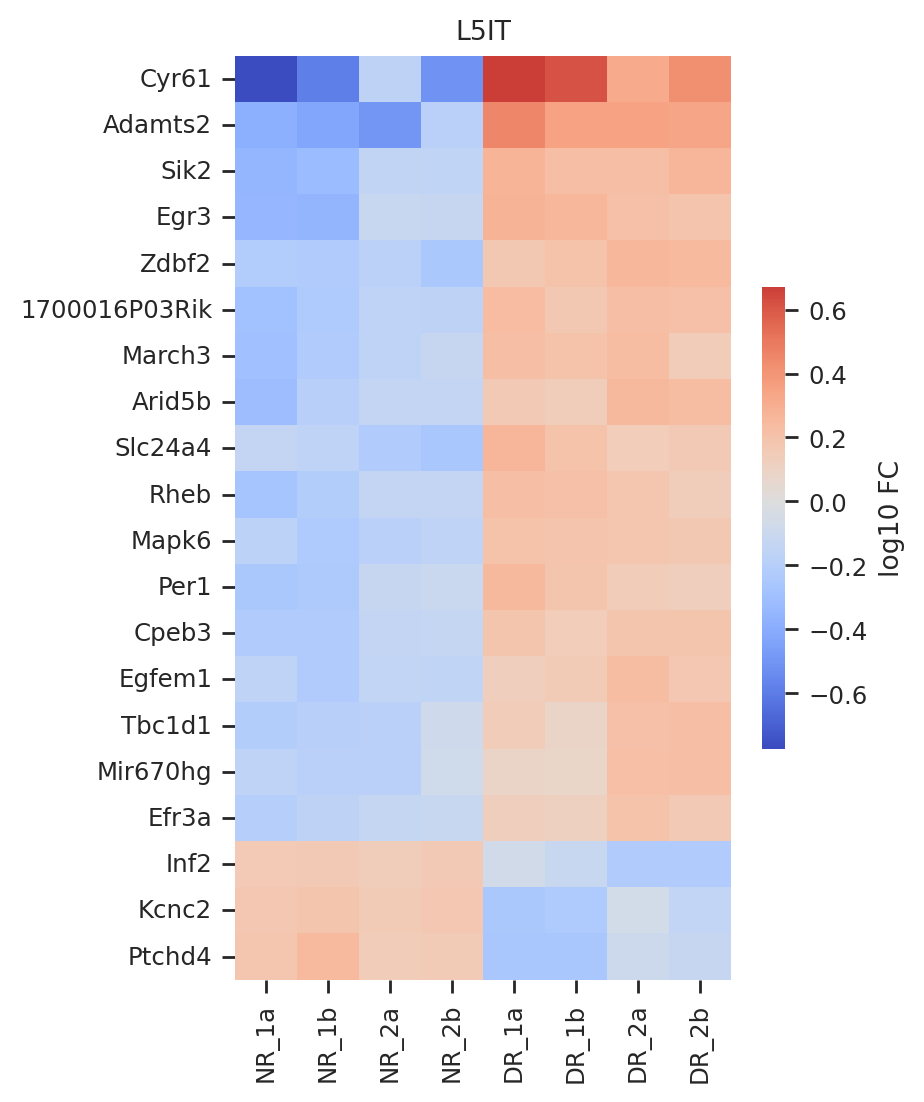

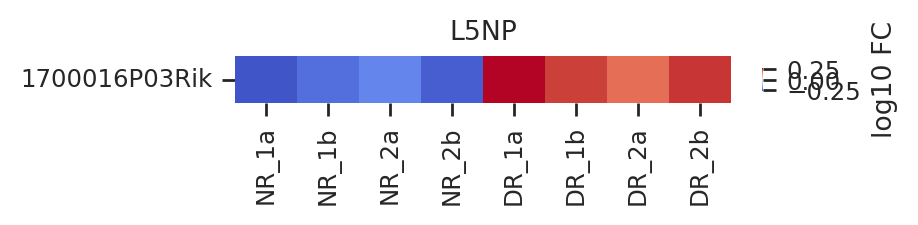

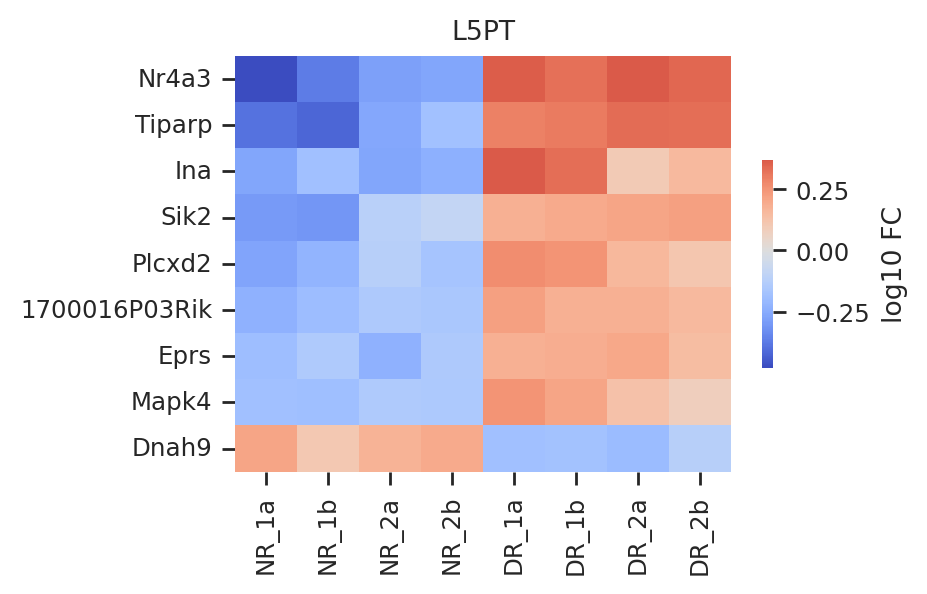

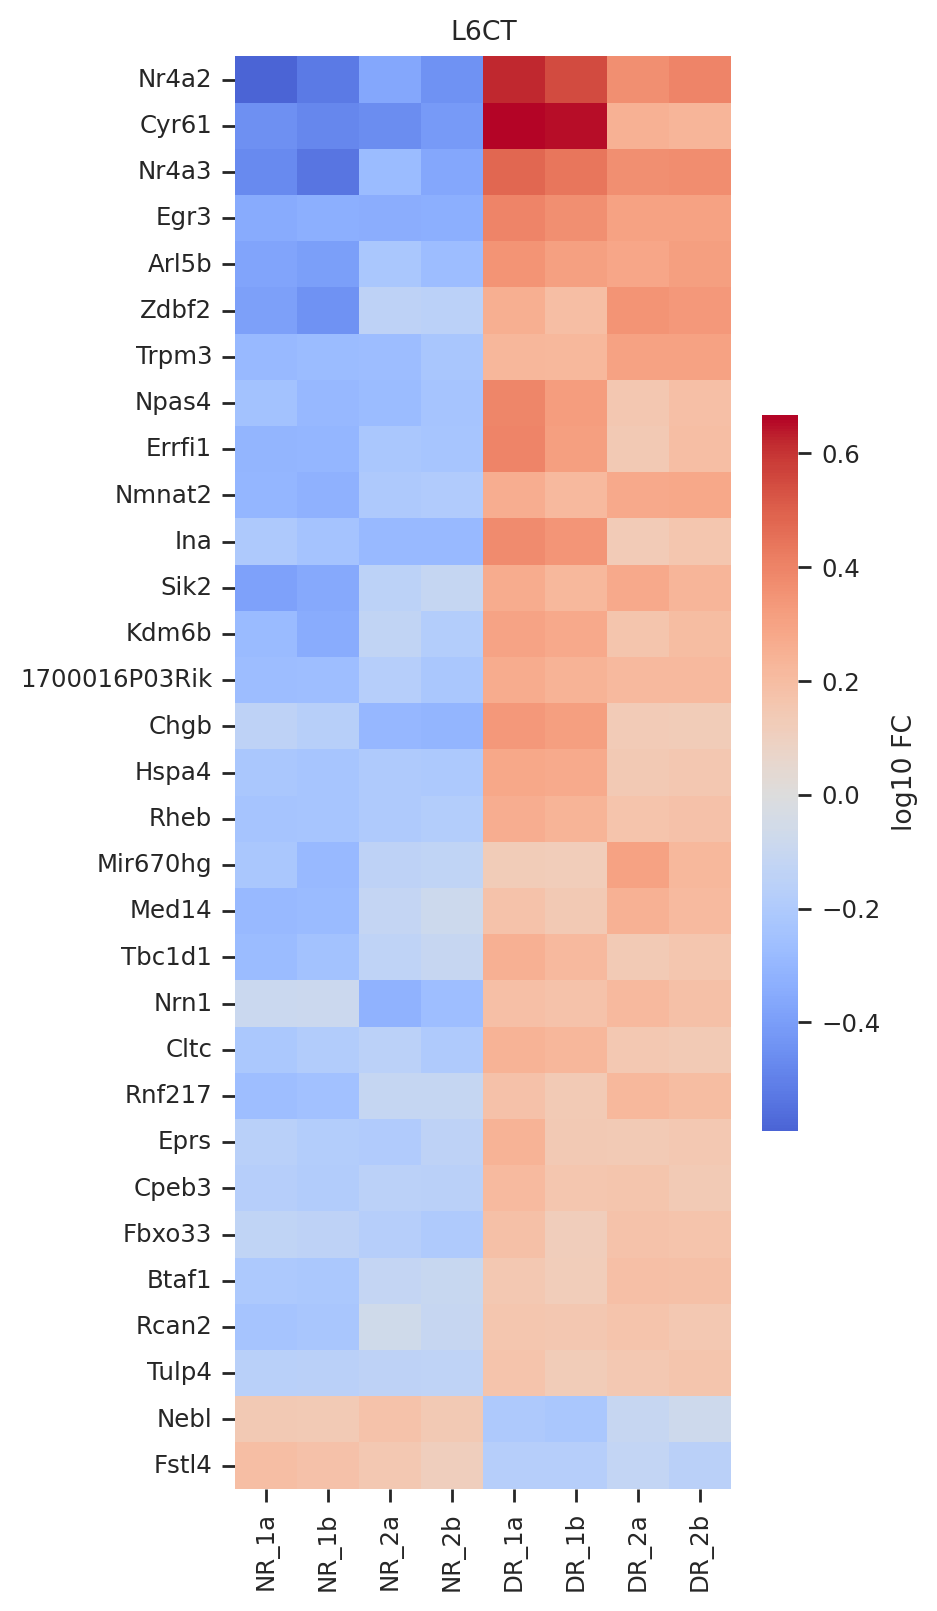

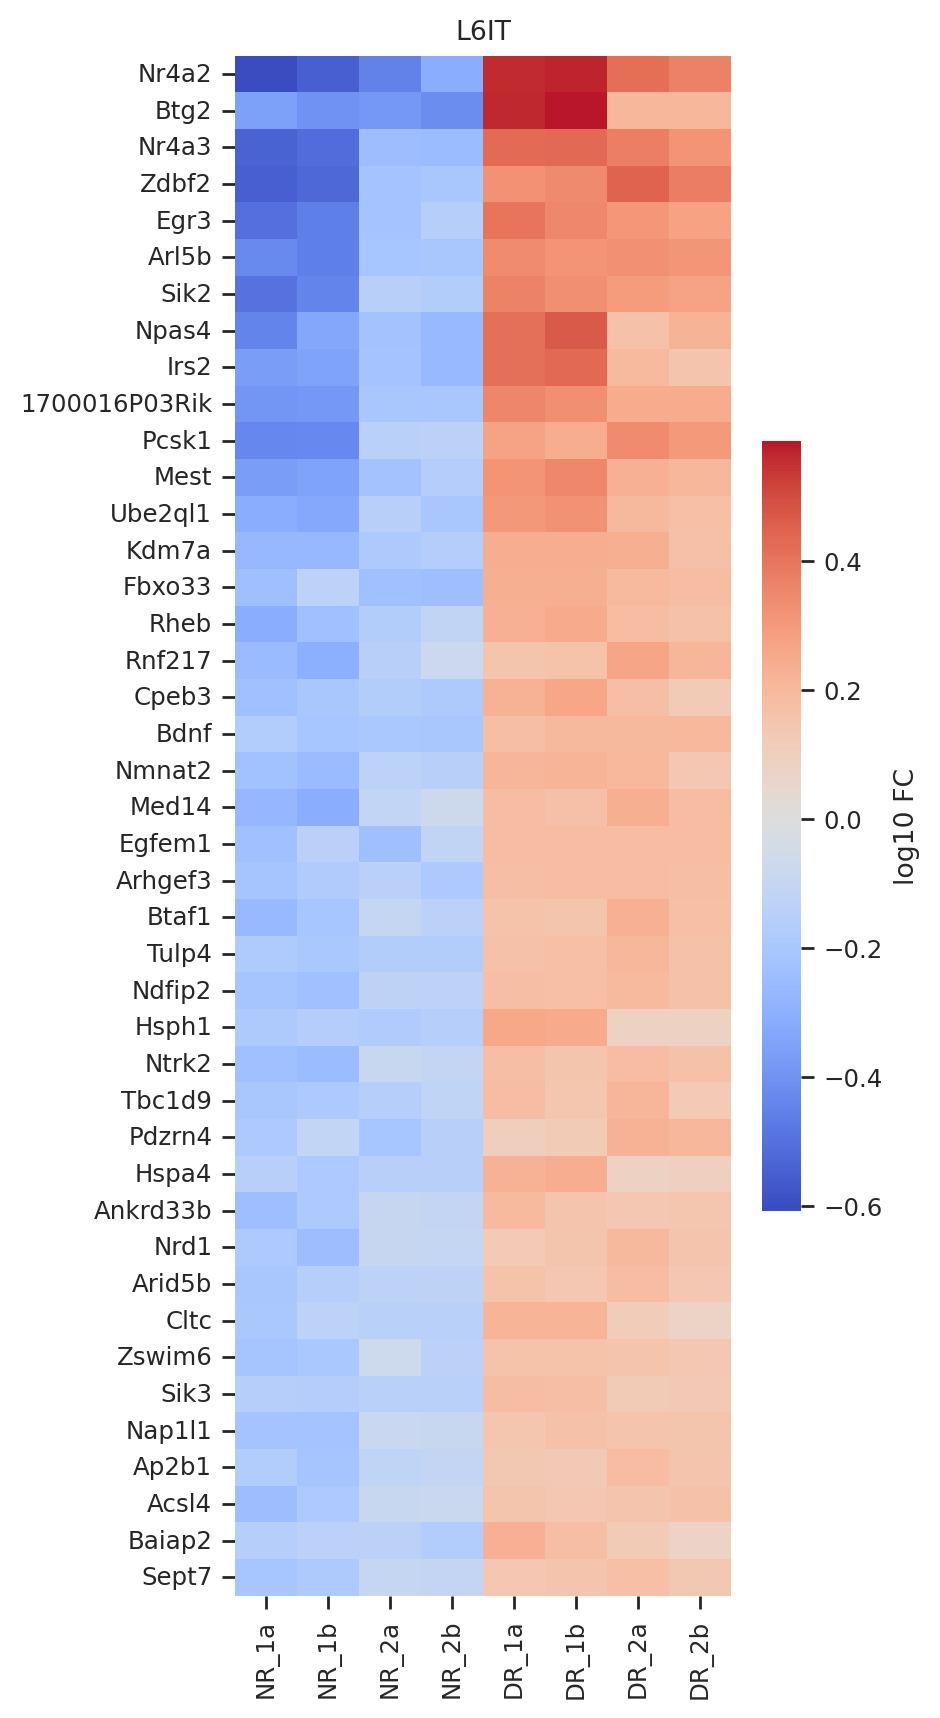

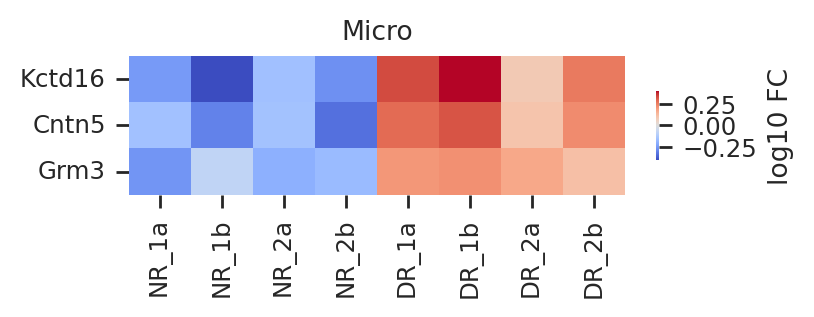

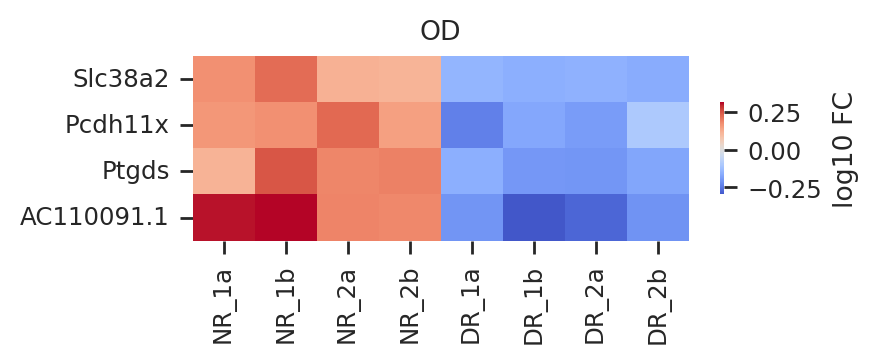

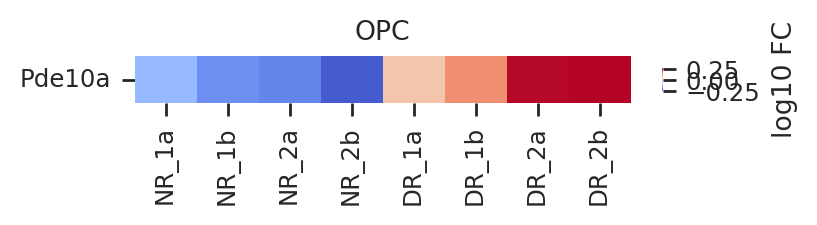

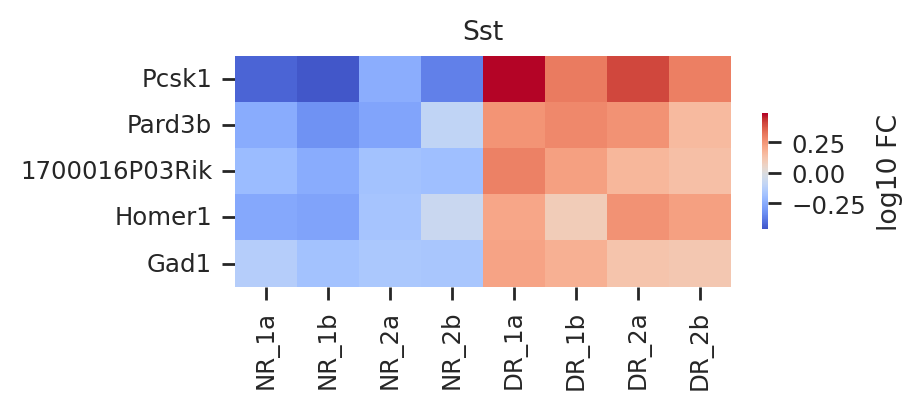

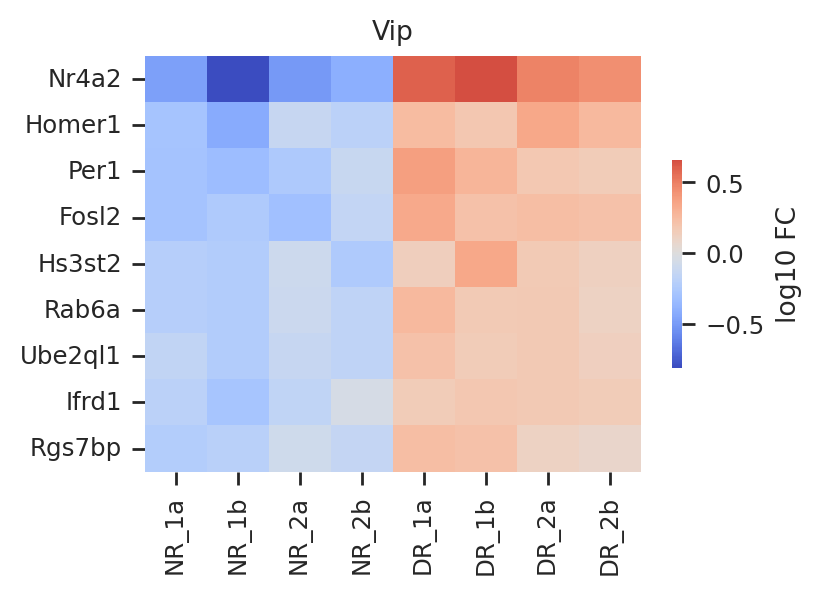

In [34]:
with sns.plotting_context('paper'):
    for i, (_type, row) in enumerate(sigsum.iterrows()):
        if row.sum() > 0:
            show_onetype(i)

# Check a few genes and see

In [35]:
pbulks.shape

(2, 4, 15, 53801)

323 2


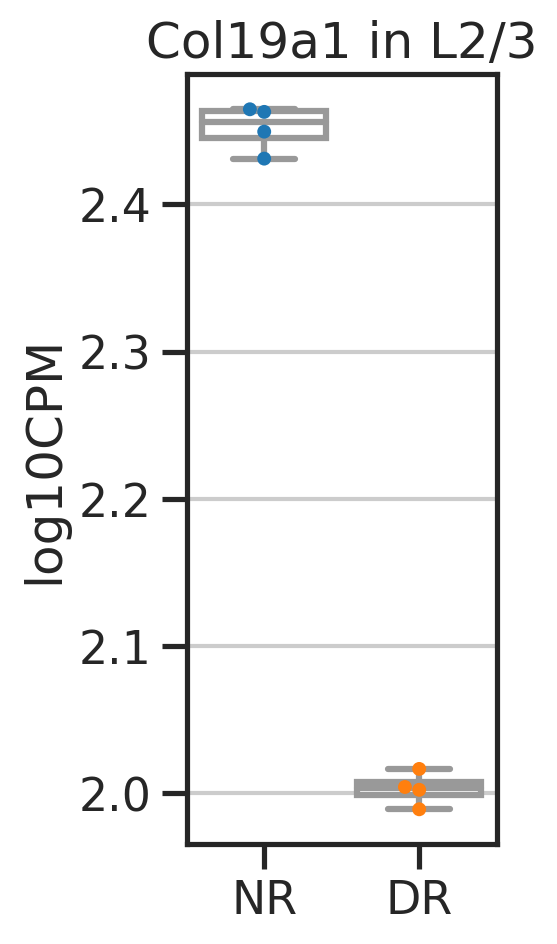

In [36]:
gene_name = 'Col19a1'
type_name = 'L2/3'
gidx = basicu.get_index_from_array(genes, [gene_name])[0]
cidx = basicu.get_index_from_array(unq_types, [type_name])[0]
p_nr, p_dr = pbulks[:,:,cidx,gidx]
print(gidx, cidx)

fig, ax = plt.subplots(figsize=(2,5))
sns.boxplot  ([p_nr, p_dr], color='white', ax=ax)
sns.swarmplot([p_nr, p_dr], s=5, ax=ax)
ax.set_xticklabels(['NR', 'DR'])
ax.set_ylabel('log10CPM')
ax.set_title(f'{gene_name} in {type_name}')
plt.show()

4577 2


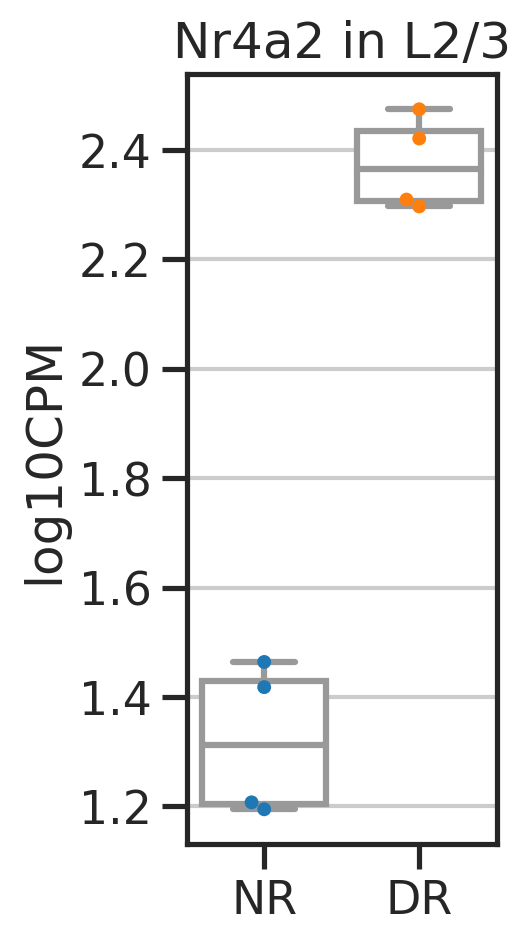

In [37]:
gene_name = 'Nr4a2'
type_name = 'L2/3'
gidx = basicu.get_index_from_array(genes, [gene_name])[0]
cidx = basicu.get_index_from_array(unq_types, [type_name])[0]
p_nr, p_dr = pbulks[:,:,cidx,gidx]
print(gidx, cidx)

fig, ax = plt.subplots(figsize=(2,5))
sns.boxplot  ([p_nr, p_dr], color='white', ax=ax)
sns.swarmplot([p_nr, p_dr], s=5, ax=ax)
ax.set_xticklabels(['NR', 'DR'])
ax.set_ylabel('log10CPM')
ax.set_title(f'{gene_name} in {type_name}')
plt.show()

13417 2


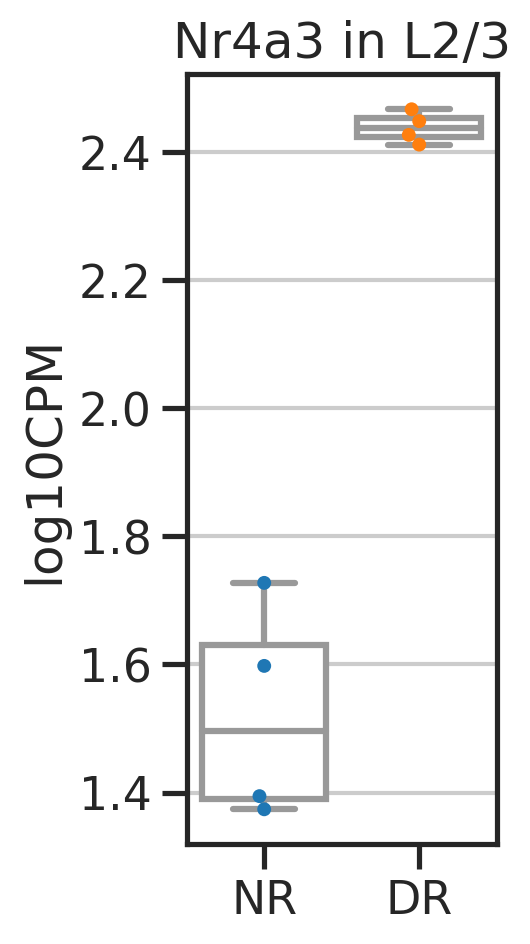

In [38]:
gene_name = 'Nr4a3'
type_name = 'L2/3'
gidx = basicu.get_index_from_array(genes, [gene_name])[0]
cidx = basicu.get_index_from_array(unq_types, [type_name])[0]
p_nr, p_dr = pbulks[:,:,cidx,gidx]
print(gidx, cidx)

fig, ax = plt.subplots(figsize=(2,5))
sns.boxplot  ([p_nr, p_dr], color='white', ax=ax)
sns.swarmplot([p_nr, p_dr], s=5, ax=ax)
ax.set_xticklabels(['NR', 'DR'])
ax.set_ylabel('log10CPM')
ax.set_title(f'{gene_name} in {type_name}')
plt.show()

# Generate the list of genes

In [39]:
types = np.array(xclsts_sel)
types

array(['Astro', 'Endo', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT',
       'L6IT', 'Micro', 'OD', 'OPC', 'Pvalb', 'Sst', 'Vip'], dtype='<U5')

In [40]:
sigsigs.shape, sigsigs_up.shape, sigsigs_dn.shape, types.shape, genes_comm.shape

((20062, 15), (20062, 15), (20062, 15), (15,), (20062,))

In [41]:
sigsigs.nonzero()[0].shape, sigsigs_up.nonzero()[0].shape, sigsigs_dn.nonzero()[0].shape

((276,), (246,), (30,))

In [42]:
res = pd.DataFrame()
gi_up, ti_up = sigsigs_up.nonzero()
gi_dn, ti_dn = sigsigs_dn.nonzero()
res['gene'] = genes_comm[np.hstack([gi_up, gi_dn])]
res['subclass'] =  types[np.hstack([ti_up, ti_dn])]
res['reason'] = ['DRup']*len(gi_up) + ['DRdn']*len(gi_dn)
res

,gene,subclass,reason
0,Coq10b,Astro,DRup
1,Coq10b,L2/3,DRup
2,Pard3b,Sst,DRup
3,Zdbf2,L2/3,DRup
4,Zdbf2,L4,DRup
...,...,...,...
271,Prodh,Astro,DRdn
272,Fkbp5,Astro,DRdn
273,Ptchd4,L2/3,DRdn
274,Ptchd4,L5IT,DRdn


In [43]:
res['gene'].unique().shape

(174,)

In [44]:
res.to_csv('../results/P28NRvsDR_DEGs_230228.csv', header=True, index=False)

In [51]:
"March3" in res['gene'].values

True

In [48]:
res['gene'].unique()

array(['Coq10b', 'Pard3b', 'Zdbf2', 'Cntnap5a', 'Map3k19', 'Btg2',
       'Nmnat2', 'Bpnt1', 'Eprs', 'Atf3', 'Celf2', 'Arl5b', 'Man1b1',
       'Slc25a25', 'Nr4a2', 'Kcnh7', 'Gad1', 'Mir670hg', 'Bdnf', 'Chp1',
       'Chgb', 'Med14', 'Emd', 'Eda', 'Acsl4', 'Egfem1', 'Hspa4l',
       'Tiparp', 'Ccnl1', 'Map9', 'Pmvk', 'Tpm3', 'Gnai3', 'Cyr61', 'Gem',
       'Nr4a3', 'Nrd1', 'Stk40', 'Dhrs3', 'Errfi1', 'Cdk11b', 'Grm3',
       'Rheb', 'Fosl2', 'Tbc1d1', 'Kctd8', 'Scarb2', 'Hsph1', 'Mest',
       'Kdm7a', '1600020E01Rik', 'Pdzrn3', 'Clstn3', 'Kras', 'Rab6a',
       'Hs3st2', 'Akap12', 'Aig1', 'Rnf217', 'Arid5b', 'Fam13c', 'Rfx4',
       'Slc25a3', 'Nudt4', 'Kitl', 'Nap1l1', 'Cand1', 'Irs2', 'Nrg1',
       'Lonrf1', 'Smad1', 'Smarca5', 'Tbc1d9', 'Lonp2', 'Vcl', 'Arf4',
       'Arhgef3', 'Nefm', 'Egr3', 'Ndfip2', 'Cntn5', 'Sept7', 'Usp2',
       'Sik3', 'Sik2', 'Mapk6', 'Gclc', 'Elovl5', 'Rasa2', 'Zbtb38',
       'Adamts2', 'Ppp2ca', 'Hspa4', 'Rapgef6', 'Ndel1', 'Per1', 'Kdm6b',
       '170